In [1]:
!pip install -qU langchain langchain-core langchain-community langchain-experimental langchain-groq langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/5

# Set up environ

In [2]:
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')

# Setup Langsmith

In [5]:
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING'] = "true"
os.environ["LANGCHAIN_PROJECT"] = "CourseLanggraph"

# Set up LLM model

In [6]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = 'gemma-7b-it',
    temperature=0.0
)

# Langgraph

### Import Libraries.

In [7]:
from typing import Annotated, Literal, TypedDict

from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.message import add_messages

In [10]:
class State(TypedDict):
  '''
    Messages have the type "list". The `add_messages` function
    in the annotation defines how this state key should be updated
    (in this case, it appends messages to the list, rather than overwriting them)
  '''
  messages:Annotated[list, add_messages]


In [12]:
# Start the process of building the graph
graph_builder = StateGraph(State)

After building the graph, our graph should interact with the LLM.

Note: Anytime we create a Node, it need to take the State paremeter of State(class). This is because, based on the statemessage, the state management should keep changing.

In [14]:
def chatbot(state:State):
  '''
    return: After any response from the chatbot, we need to update the message variable.
    llm invoke: Specifically invoke from the state message, which will hold the user query
  '''

  return {"messages" : llm.invoke(state['messages'])}

### Explanation

Every time a user queries, messages will be appended to the messages variable in the class and,

once messages get appended LLM will invoke that messages and,

the llm response will again get appended back to the messages variable.

# Add Node: Add the chatbot into the graph with graphbuilder

In [15]:
graph_builder.add_node("chatbot", chatbot)

# Connect the chatbot Node to start and end node

In [16]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile Graph

In [17]:
graph = graph_builder.compile()

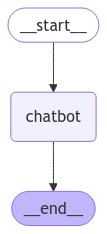

In [18]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

# Run Graph

In [19]:
while True:
  user_input = input("Ask: ")

  if user_input == 'q':
    print("Bye")
    break

  for event in graph.stream({'messages' : ('user', user_input)}):
    print(event)
    print("*****")
    print(event.values())
    print('******')

    for value in event.values():
      print(value)
      print('*******')
      print(value['messages'])
      print('*******')
      print('Assistant: ', value['messages'].content)

Ask: Hey there?
{'chatbot': {'messages': AIMessage(content="Hey there! 👋 It's great to hear from you. What can I do for you today? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 12, 'total_tokens': 35, 'completion_time': 0.026930396, 'prompt_time': 0.007311939, 'queue_time': 0.007793632, 'total_time': 0.034242335}, 'model_name': 'gemma-7b-it', 'system_fingerprint': 'fp_7d8efeb0b1', 'finish_reason': 'stop', 'logprobs': None}, id='run-7db5e1db-6c73-4745-a21c-a11215b6de11-0', usage_metadata={'input_tokens': 12, 'output_tokens': 23, 'total_tokens': 35})}}
*****
dict_values([{'messages': AIMessage(content="Hey there! 👋 It's great to hear from you. What can I do for you today? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 12, 'total_tokens': 35, 'completion_time': 0.026930396, 'prompt_time': 0.007311939, 'queue_time': 0.007793632, 'total_time': 0.034242335}, 'model_name': 'gemma-7